A little pre-requisites about array and reshape

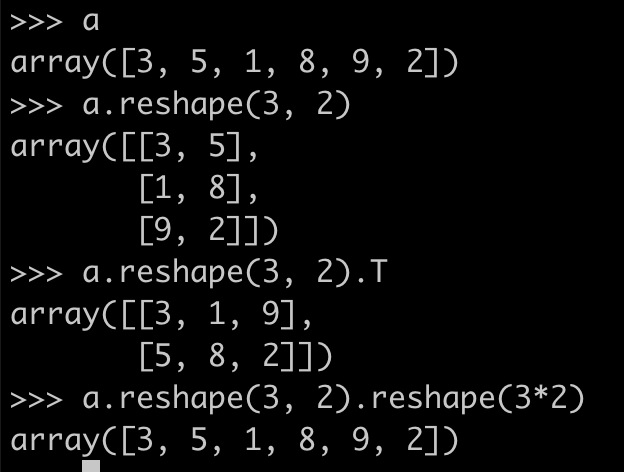

In [68]:
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

### Read image and store it as an 3 dimensional array

In [69]:
img = Image.open(f"photo.jpeg")
print(img)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1548x2048 at 0x1193E4070>


In digital imaging, a pixel(or picture element) is the smallest item of information in an image. 

In [70]:
img_arr = np.array(img, dtype='int32')
print('The shape is {}, meaning {} x {} pixels (picture elements) with {}-coded RGB.\n'.format(str(img_arr.shape),\
                                                                                str(img_arr.shape[0]),\
                                                                                str(img_arr.shape[1]),\
                                                                                str(img_arr.shape[2]))) # 3 dimensional image array
print('img_arr\'s 1st pixel:','\n',img_arr[0][0])
print('')
print('img_arr\'s last pixel:','\n',img_arr[-1][-1])

The shape is (2048, 1548, 3), meaning 2048 x 1548 pixels (picture elements) with 3-coded RGB.

img_arr's 1st pixel: 
 [231 218 210]

img_arr's last pixel: 
 [100  90  89]


### Use the 3 dimensional array to display the image

In [71]:
arr = img_arr.astype(dtype='uint8')
print(type(arr))
print('\nShape:', arr.shape, '\n')
print(arr[0])

<class 'numpy.ndarray'>

Shape: (2048, 1548, 3) 

[[231 218 210]
 [231 218 210]
 [231 218 210]
 ...
 [173 165 152]
 [174 167 151]
 [175 168 152]]


`matplotlib.pyplot.imshow(X)`

Display data as an *inline* image

`X`: array-like or PIL image. The image data. Supported array shapes are:

- (M, N): an image with scalar data. The values are mapped to colors using normalization and a colormap. See parameters norm, cmap, vmin, vmax.
- (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
- (M, N, 4): an image with RGBA values (0-1 float or 0-255 int), i.e. including transparency.
- The first two dimensions (M, N) define the rows and columns of the image. Out-of-range RGB(A) values are clipped.

Text(0.5, 1.0, 'Original')

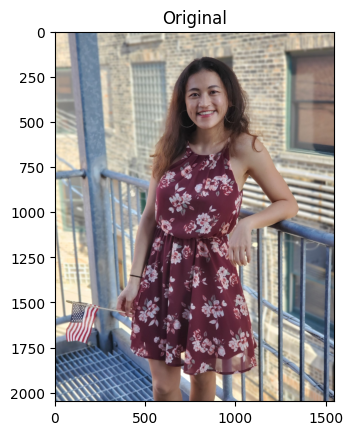

In [104]:
imshow(arr)
plt.title('Original')

`Image.fromarray`

Creates an image memory from an object exporting the array interface (using the buffer protocol).



In [73]:
img = Image.fromarray(arr, mode='RGB') # (3x8-bit pixels, true color)
print(type(img))
# img

<class 'PIL.Image.Image'>


In [74]:
try:
    Image.fromarray(arr, mode='CMYK') # (4x8-bit pixels, color separation)
except ValueError:
    print('Failed - CMYK is for 4 dimensional array')


Failed - CMYK is for 4 dimensional array


### Reshape the matrix by transforming "img_arr" from a "3-D" matrix to a flattened "2-D" matrix  
It has 3 columns corresponding to the RGB values for each pixel

In [75]:
img_reshaped = img_arr.reshape([img_arr.shape[0]*img_arr.shape[1], 3])
print(img_reshaped.shape) # 2048*1548 = 3170304

(3170304, 3)


In [76]:
print('img_reshaped\'s 1st pixel:','\n',img_reshaped[0])
print('')
print('img_reshaped\'s last pixel:','\n',img_reshaped[-1])

img_reshaped's 1st pixel: 
 [231 218 210]

img_reshaped's last pixel: 
 [100  90  89]


The two examples above are same as the orginal 3-dimensional array

### Create k-means function that groups a large volume of inputs into a small number of clusters

In [77]:
print('# Low and high are both specified.')
print(np.random.randint(low=2, high=5, size=10)) 
print('\n# If high is None (the default), then results are from [0, low).')
print(np.random.randint(2, size=10)) 

# Low and high are both specified.
[2 4 3 2 2 3 4 2 2 4]

# If high is None (the default), then results are from [0, low).
[1 0 1 0 0 1 1 1 0 1]


In [78]:
# initialize k centers randomly
def initialize_centers(X, k):
    return X[np.random.randint(len(X), size=k), : ] # slicing to returns centers as a (k x d) numpy array.

In [79]:
# computes a distance matrix, storing the squared distance from point x to center j. 
def compute_squared_distance(X, centers):
    m = len(X) 
    k = len(centers) 
    
    S = np.empty((m, k)) 
    
    for i in range(m): 
        S[i,:] = np.linalg.norm(X[i,:] - centers, ord = 2, axis = 1) ** 2
        
    return S

In [80]:
def compute_squared_distance_v2(X, centers):
    ans = []
    for i in range(len(centers)):
        ans.append(np.sum((X - centers[i])**2, axis = 1))
    
    # check out the concept under the pre-requisite section
    a = np.array(ans).reshape(centers.shape[1], X.shape[0]) # first horizontal, then vertical
    b = a.T # first vertical, then horizontal
    return b


In [81]:
# Given a clustering (i.e., a set of points and assignment of labels), compute the center of each cluster.
def find_centers(X, labels):
    # X[:m, :d] == m points, each of dimension d
    m, d = X.shape
    
    # this time to find one more cluster than previously
    k = int(max(labels) + 1)
    
    assert m == len(labels) # the number of points in X must equal the number of assigned labels
    assert (min(labels) >= 0) # labels must start from 0

    # create a blank array for original plus one more cluster
    centers = np.empty((k, d)) 
    for i in range(k):
        # Compute the new center of cluster j, the mean of all points within the same cluster i
        centers[i, :] = np.mean(X[labels == i, :], axis = 0)
    return centers    
    

In [82]:
# use the squared distance matrix to find each point's minimum squared distance and assign a "cluster label" to it
def assign_cluster_labels(S):
    return np.argmin(S, axis = 1)

In [83]:
# Given the squared distances, return the within-cluster sum of squares.
def calculate_wcss(S):
    return np.sum(np.amin(S, axis=1)) # Return the minimum of an array or minimum along an axis.


In [84]:
def kmeans(X, k,
           starting_centers=None,
           max_steps=np.inf):
    
    # initialize k centers by choice or randomly
    if starting_centers is None:
        centers = initialize_centers(X, k)
    else:
        centers = starting_centers
        
    converged = False
    # by default, give every point the label of 0, to update later
    labels = np.zeros(len(X))
    wcss = 0
    
    i = 1
    # keep iterating as long as it's not converged and hasn't hit the maximum iteration allowance
    while (not converged) and (i <= max_steps):
        old_centers = centers
        old_wcss = wcss
        
        S = compute_squared_distance(X, old_centers)
        labels = assign_cluster_labels(S)
        
        centers = find_centers(X, labels)
        wcss = calculate_wcss(S)
        print ("iteration", i, "WCSS = ", wcss)
        i += 1
        
        # break the loop if new iteration is not better (a.k.a wcss is not less)
        if old_wcss == wcss:
            converged = True
            
    return labels

### Apply the k-means function to divide the image in 3 clusters. 
The result would be a vector named labels, which assigns the label to each pixel.


In [85]:
clusters = kmeans(img_reshaped, k=3, starting_centers=img_reshaped[[0, 0], :],max_steps=np.inf)

iteration 1 WCSS =  97530990352.0
iteration 2 WCSS =  29526250039.818996
iteration 3 WCSS =  29526250039.818996


In [86]:
clusters

array([0, 0, 0, ..., 0, 0, 0])

In [87]:
set(clusters)

{0}

Specifying 1 point by [0,0] was a wrong setup, it then returned only 1 cluster (a.k.a label 0).

In [88]:
clusters2 = kmeans(img_reshaped, k=3, starting_centers=None,max_steps=np.inf)

iteration 1 WCSS =  9861553301.0
iteration 2 WCSS =  5754389501.577468
iteration 3 WCSS =  5401574498.467954
iteration 4 WCSS =  5314484579.475747
iteration 5 WCSS =  5275609486.851461
iteration 6 WCSS =  5253545638.264234
iteration 7 WCSS =  5240617942.684406
iteration 8 WCSS =  5233173217.622128
iteration 9 WCSS =  5229092887.443631
iteration 10 WCSS =  5226957442.188182
iteration 11 WCSS =  5225813863.665085
iteration 12 WCSS =  5225153345.833356
iteration 13 WCSS =  5224782598.43032
iteration 14 WCSS =  5224630651.776304
iteration 15 WCSS =  5224546804.933876
iteration 16 WCSS =  5224500483.585667
iteration 17 WCSS =  5224474521.714799
iteration 18 WCSS =  5224457558.060966
iteration 19 WCSS =  5224451117.510562
iteration 20 WCSS =  5224448481.550121
iteration 21 WCSS =  5224446317.276529
iteration 22 WCSS =  5224445792.13516
iteration 23 WCSS =  5224445449.779306
iteration 24 WCSS =  5224445310.035106
iteration 25 WCSS =  5224445174.36059
iteration 26 WCSS =  5224445125.848503
ite

In [89]:
clusters2

array([2, 2, 2, ..., 0, 0, 0])

In [90]:
set(clusters2)

{0, 1, 2}

It looks more reasonable now - three clusters (three labels).

### Calculate the mean of each cluster 

In [91]:
centers = {}
centers[0] = np.mean(img_reshaped[clusters2==0], axis = 0)
centers[1] = np.mean(img_reshaped[clusters2==1], axis = 0)
centers[2] = np.mean(img_reshaped[clusters2==2], axis = 0)
centers

{0: array([76.58980564, 51.75159523, 62.84979543]),
 1: array([137.99913238, 133.08534164, 137.85557383]),
 2: array([202.25733024, 195.26233339, 182.26843136])}

### Generate a matrix of the same dimensions, where each pixel is replaced by the cluster center to which it belongs.

In [92]:
img_clustered = np.array([centers[i] for i in clusters2])
img_clustered

array([[202.25733024, 195.26233339, 182.26843136],
       [202.25733024, 195.26233339, 182.26843136],
       [202.25733024, 195.26233339, 182.26843136],
       ...,
       [ 76.58980564,  51.75159523,  62.84979543],
       [ 76.58980564,  51.75159523,  62.84979543],
       [ 76.58980564,  51.75159523,  62.84979543]])

### Display the clustered image

In [93]:
arr_clustered = img_clustered.astype(dtype='uint8')
print(type(arr_clustered))
print()
print(arr_clustered)

<class 'numpy.ndarray'>

[[202 195 182]
 [202 195 182]
 [202 195 182]
 ...
 [ 76  51  62]
 [ 76  51  62]
 [ 76  51  62]]


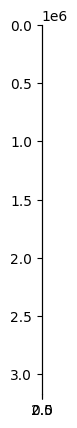

In [94]:
imshow(arr_clustered)

In [95]:
arr_clustered.shape

(3170304, 3)

**Problem** The image is not properly showing because of the wrong shape - 3,170,304 meaning one long line of pixels. Note that the y axis is up to 10e6. 
**Solution** It should be 3-dimensional of (2048, 1548, 3)  - 2048 X 1548 representing the 2D picture.

In [96]:
R, G, B = arr.shape
print(R, G, B)

2048 1548 3


In [97]:
arr_clustered2 = arr_clustered.reshape([R, G, B])
print(type(arr_clustered2))
print("\nShape:", arr_clustered2.shape, '\n')
print(arr_clustered2[0])

<class 'numpy.ndarray'>

Shape: (2048, 1548, 3) 

[[202 195 182]
 [202 195 182]
 [202 195 182]
 ...
 [137 133 137]
 [202 195 182]
 [202 195 182]]


Text(0.5, 1.0, 'K=3 Clusters')

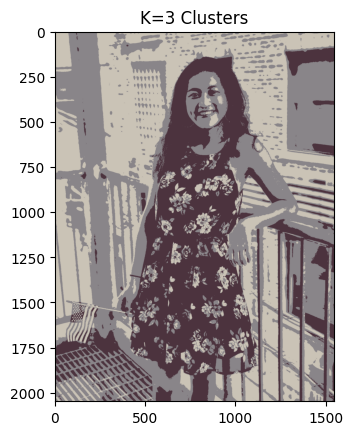

In [98]:
imshow(arr_clustered2)
plt.title('K=3 Clusters')

### Experiment with different clusters! 

In [99]:
def one_stop_function(original_image, reshaped_image, k, starting_centers, max_steps):
    # Apply the k-means function
    cluster = kmeans(reshaped_image, k=k, starting_centers=None,max_steps=np.inf)
    assert len(set(cluster)) == k, "Number of identified clusters does not match the specified cluster numbers."
    
    # Calculate the mean of each cluster
    centers = {}
    for i in range(len(set(cluster))):
        centers[i] = np.mean(reshaped_image[cluster==i], axis = 0)
    
    # Generate a matrix 
    img_clustered = np.array([centers[i] for i in cluster])
    
    # Reshape the matrix to the shape of the original image
    R, G, B = original_image.shape
    return img_clustered.astype(dtype='uint8').reshape([R, G, B])

iteration 1 WCSS =  13845734602.0
iteration 2 WCSS =  10462381367.751833
iteration 3 WCSS =  9775685023.571686
iteration 4 WCSS =  9611864721.208366
iteration 5 WCSS =  9576699312.285011
iteration 6 WCSS =  9569236947.2001
iteration 7 WCSS =  9567500851.112175
iteration 8 WCSS =  9567112666.020752
iteration 9 WCSS =  9567048328.545515
iteration 10 WCSS =  9567032114.584272
iteration 11 WCSS =  9567029386.72368
iteration 12 WCSS =  9567028355.187643
iteration 13 WCSS =  9567027549.166855
iteration 14 WCSS =  9567027208.04366
iteration 15 WCSS =  9567027199.245916
iteration 16 WCSS =  9567027199.245916


Text(0.5, 1.0, 'K=2 Clusters')

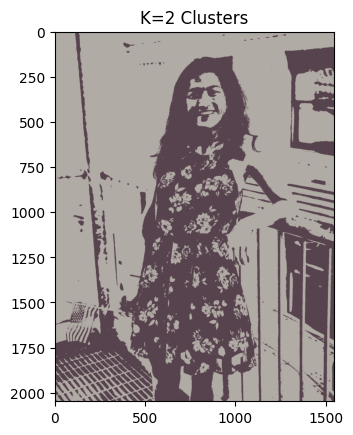

In [100]:
k_2 = one_stop_function(original_image=img_arr,
                        reshaped_image=img_reshaped, k=2, starting_centers=None, max_steps=np.inf)

# Display the clustered image 
imshow(k_2)
plt.title('K=2 Clusters')

iteration 1 WCSS =  7502927041.0
iteration 2 WCSS =  3566065539.1099024
iteration 3 WCSS =  3471252095.7042394
iteration 4 WCSS =  3420742178.690807
iteration 5 WCSS =  3377430020.095311
iteration 6 WCSS =  3335844973.6106005
iteration 7 WCSS =  3298907071.093067
iteration 8 WCSS =  3266925504.40333
iteration 9 WCSS =  3240175371.6248393
iteration 10 WCSS =  3216851962.1074862
iteration 11 WCSS =  3196507125.7626243
iteration 12 WCSS =  3178680323.022674
iteration 13 WCSS =  3161874111.634402
iteration 14 WCSS =  3145990231.755654
iteration 15 WCSS =  3129861532.612235
iteration 16 WCSS =  3111556962.1254044
iteration 17 WCSS =  3090356609.6014314
iteration 18 WCSS =  3066827261.157956
iteration 19 WCSS =  3043746787.8262877
iteration 20 WCSS =  3023326560.1819563
iteration 21 WCSS =  3006826227.0657682
iteration 22 WCSS =  2994121276.48974
iteration 23 WCSS =  2984295413.3729353
iteration 24 WCSS =  2976530978.2924886
iteration 25 WCSS =  2970235804.89278
iteration 26 WCSS =  29650318

Text(0.5, 1.0, 'K=5 Clusters')

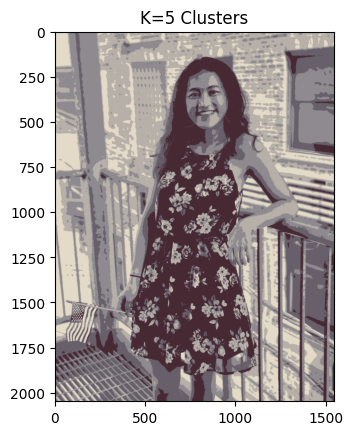

In [101]:
k_5 = one_stop_function(original_image=img_arr,
                        reshaped_image=img_reshaped, k=5, starting_centers=None, max_steps=np.inf)

# Display the clustered image 
imshow(k_5)
plt.title('K=5 Clusters')

iteration 1 WCSS =  3823921219.0
iteration 2 WCSS =  2420660848.9279876
iteration 3 WCSS =  2070181997.7575762
iteration 4 WCSS =  1902835309.3825347
iteration 5 WCSS =  1806373178.4823658
iteration 6 WCSS =  1748232083.418075
iteration 7 WCSS =  1709565401.2722638
iteration 8 WCSS =  1681944410.1917949
iteration 9 WCSS =  1660974510.679282
iteration 10 WCSS =  1644390052.9900677
iteration 11 WCSS =  1629791365.847404
iteration 12 WCSS =  1613822971.7939003
iteration 13 WCSS =  1594943474.0325782
iteration 14 WCSS =  1577441316.7216208
iteration 15 WCSS =  1562464452.5043666
iteration 16 WCSS =  1548840752.6592598
iteration 17 WCSS =  1534417079.7307649
iteration 18 WCSS =  1520475455.5099752
iteration 19 WCSS =  1509012203.6756227
iteration 20 WCSS =  1500258858.3701546
iteration 21 WCSS =  1493355514.6736467
iteration 22 WCSS =  1488159390.1524642
iteration 23 WCSS =  1483906970.1917415
iteration 24 WCSS =  1480580864.5320358
iteration 25 WCSS =  1477815166.7116146
iteration 26 WCSS 

Text(0.5, 1.0, 'K=10 Clusters')

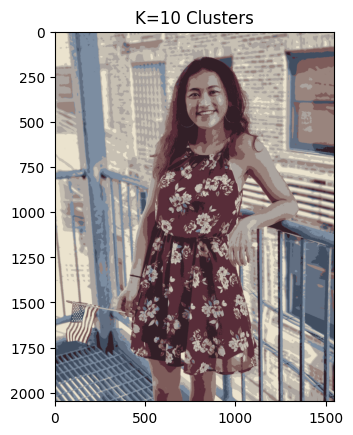

In [103]:
k_10 = one_stop_function(original_image=img_arr,
                         reshaped_image=img_reshaped, k=10, starting_centers=None, max_steps=np.inf)

# Display the clustered image 
imshow(k_10)
plt.title('K=10 Clusters')

### Summary: 
The processing time is not linear but exponential because of the big dataset.

- k=2 clusters took 14-16 iterations until convergence
- k=3 clusters took 30-33 iterations until convergence
- k=5 clusters took 70-85 iterations until convergence
- k=10 clusters took 90-166 iterations until convergence
